# Otobüs Hareket Saatleri ve Durakları Verisetleri Analizi

Bu çalışmada İzmir’de 757 ve 619 numaralı otobüs hatları için saat–gün bazında sefer yoğunluğunu çıkardım. Hareket saatlerini okuyup TARIFE_ID’yi gün tipine çevirdim, gidiş/dönüş saatlerini tek kolonda birleştirip gün×saat kırılımında sefer sayılarını saydım ve ısı haritalarını ürettim. Duraklar verisinden iki hattın duraklarını harita üzerinde gösterdim ve Ulukent Aktarma Merkezi ile Bakırçay Üniversitesi için 300 m içinde durak olup olmadığını mesafe (haversine) hesabıyla doğruladım. Ek olarak, tüm hatlar için en çok sefer yapanlar sıralamasını çıkardım. (İleride K-Means ile hat profili kümeleme eklenebilir.)

In [41]:
import os
os.environ["OMP_NUM_THREADS"] = "2"  

import os, random, numpy as np
os.environ["OMP_NUM_THREADS"] = "2"  # Windows+MKL uyarısını bastırmak için
random.seed(42); np.random.seed(42)


### Veri Okuma ve Kurulum

In [43]:

# Grafiklerin inline görünmesi
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dosyalarımızı tanımlayalım
DESKTOP = Path.home() / "Desktop"
p_hareket = DESKTOP / "eshot-otobus-hareketsaatleri.csv"
p_durak   = DESKTOP / "eshot-otobus-duraklari.csv"

# CSV'leri okuyalım
hareket = pd.read_csv(p_hareket, sep=";", encoding="utf-8")
duraklar = pd.read_csv(p_durak, sep=";", encoding="utf-8")

# Tip ve hızlı kontrol yapalım
hareket["HAT_NO"] = pd.to_numeric(hareket["HAT_NO"], errors="coerce")
print("hareket:", hareket.shape, "| duraklar:", duraklar.shape)
display(hareket.head(3))
display(duraklar.head(3))


hareket: (96365, 11) | duraklar: (11605, 5)


,HAT_NO,TARIFE_ID,GIDIS_SAATI,DONUS_SAATI,SIRA,GIDIS_ENGELLI_DESTEGI,DONUS_ENGELLI_DESTEGI,BISIKLETLI_GIDIS,BISIKLETLI_DONUS,GIDIS_ELEKTRIKLI_OTOBUS,DONUS_ELEKTRIKLI_OTOBUS
0,5,1,06:00,06:40,1,True,True,True,True,False,False
1,5,1,06:25,07:05,2,True,True,True,True,False,False
2,5,1,06:50,07:30,3,True,True,True,True,False,False


,DURAK_ID,DURAK_ADI,ENLEM,BOYLAM,DURAKTAN_GECEN_HATLAR
0,10005,Bahribaba,38.415268,27.127640,32
1,10007,Bahribaba,38.415144,27.127720,29-30
2,10008,Bahribaba,38.415187,27.127567,15


### Seçilen Hatlar

In [45]:
# TARIFE_ID → Gün adı olarak gruplayalım
tarife_map = {1: "Hafta içi", 2: "Cumartesi", 3: "Pazar"}
hareket["GUN"] = hareket["TARIFE_ID"].map(tarife_map)

# Gidiş/Dönüş saatlerini tek kolonda toplayalım 
long = pd.melt(
    hareket,
    id_vars=["HAT_NO", "TARIFE_ID", "GUN"],
    value_vars=["GIDIS_SAATI", "DONUS_SAATI"],
    var_name="YON",
    value_name="SAAT_STR",
)

# Geçersiz saatleri atalım ve 0–23 saat değerini çıkar
long = long[long["SAAT_STR"].str.match(r"^\d{2}:\d{2}$", na=False)].copy()
long["SAAT"] = pd.to_datetime(long["SAAT_STR"], format="%H:%M").dt.hour


# Okul için kullandığımız hatları seçmek istedim.Fakat 812 sonradan eklenen bir hat olduğu için verisetine dahil edilmemiş. Bu yüzden 619 ve 757 ile çalışmaya devam ediyorum.
print("long:", long.shape, "| 757 var mı?", (long["HAT_NO"]==757).any(), "| 619 var mı?", (long["HAT_NO"]==619).any(), "| 812 var mı?", (long["HAT_NO"]==812).any())


long: (180760, 6) | 757 var mı? True | 619 var mı? True | 812 var mı? False


### Sefer Sıklığı Isı Haritaları

Kaydedildi: C:/Users/cemre/Desktop/heatmap_hat_757.png


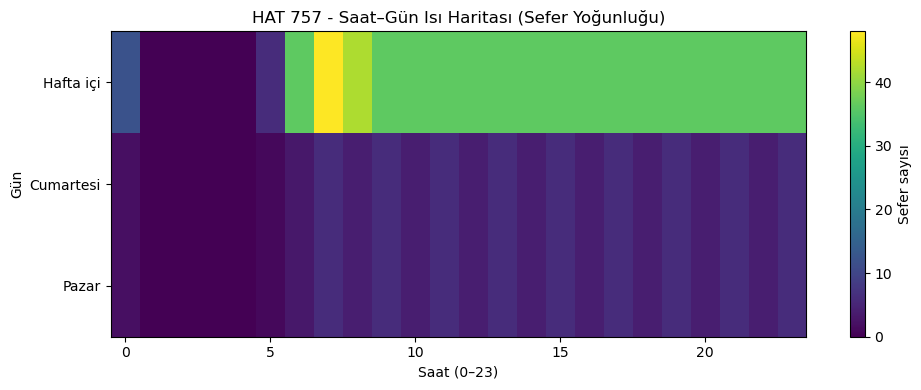

Kaydedildi: C:/Users/cemre/Desktop/heatmap_hat_619.png


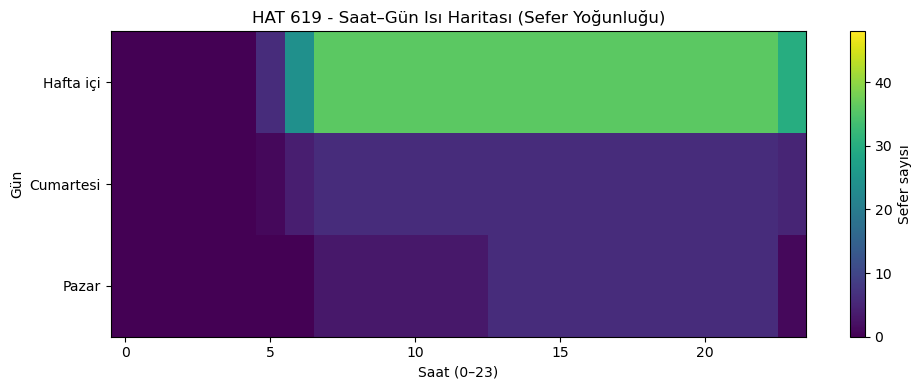

In [47]:

def plot_heatmap(df_long: pd.DataFrame, hat_no: int, save_dir=DESKTOP, vmin=0, vmax=None):
    gun_sira = ["Hafta içi", "Cumartesi", "Pazar"]
    df_hat = df_long[df_long["HAT_NO"] == hat_no].copy()
    assert not df_hat.empty, f"HAT {hat_no}: veri bulunamadı."

    pivot = pd.crosstab(df_hat["GUN"], df_hat["SAAT"]).reindex(gun_sira).fillna(0)
    pivot = pivot.reindex(columns=list(range(24)), fill_value=0)  # 0–23 eksiksiz

    # vmax dışarıdan verilmemişse bu hattın tavanını kullan
    vmax = pivot.values.max() if vmax is None else vmax

    fig, ax = plt.subplots(figsize=(10,4))
    im = ax.imshow(pivot.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_title(f"HAT {hat_no} - Saat–Gün Isı Haritası (Sefer Yoğunluğu)")
    ax.set_xlabel("Saat (0–23)")
    ax.set_ylabel("Gün")
    ax.set_yticks(range(len(gun_sira)))
    ax.set_yticklabels(gun_sira)
    fig.colorbar(im, ax=ax, label="Sefer sayısı")
    fig.tight_layout()

    out_png = (save_dir / f"heatmap_hat_{hat_no}.png").as_posix()
    fig.savefig(out_png, dpi=150)
    print("Kaydedildi:", out_png)

    plt.show()
    plt.close(fig)

# --- ORTAK vmax HESABI ve ÇİZİM 
subset = long[ long["HAT_NO"].isin([757, 619]) ]
cnt = (subset.groupby(["HAT_NO","GUN","SAAT"]).size().rename("cnt"))
global_vmax = int(cnt.max()) if not cnt.empty else None



for h in [757, 619]:
    plot_heatmap(long, h, vmin=0, vmax=global_vmax)



ISI HARİTALARI YORUMU

757: Hafta içi 06–08’de keskin bir sabah zirvesi var; 08 sonrası gün boyu yüksek ve sürekli bir plato görülüyor. Hafta sonu belirgin şekilde seyrekleşiyor, Pazar en düşük.
619: Hafta içi 06’dan sonra hızla yükselip gün boyunca yüksek kalıyor; akşama kadar hizmet güçlü. Hafta sonu düşüyor, Pazar en düşük.
Karşılaştırma: İki hat da hafta içi daha sık; 757’de zirve daha keskin, 619’da yoğunluk daha dengeli ve gün boyu yayılmış. (Haritalar aynı renk ölçeğiyle çizildi, bu yüzden farklar doğrudan karşılaştırılabilir.)


### Durakların Haritada Gösterimi

In [49]:
# HARİTA BLOĞU 
import pandas as pd, folium
from pathlib import Path
from IPython.display import display, IFrame

assert 'duraklar' in globals(), "Önce duraklar CSV'sini oku: duraklar = pd.read_csv(..., sep=';')"

def stops_for(hat_no: int, df: pd.DataFrame) -> pd.DataFrame:
    s = df["DURAKTAN_GECEN_HATLAR"].astype(str)
    def has_exact(cell):
        raw = str(cell)
        for sep in [";", ",", "/", "\\", "|", "-", " "]:
            raw = raw.replace(sep, "|")
        toks = [t.strip() for t in raw.split("|") if t.strip()]
        return str(hat_no) in toks
    mask = s.apply(has_exact) | s.str.contains(fr"\b{hat_no}\b", regex=True, na=False)
    out = df[mask].copy()
    out["ENLEM"]  = pd.to_numeric(out["ENLEM"], errors="coerce")
    out["BOYLAM"] = pd.to_numeric(out["BOYLAM"], errors="coerce")
    return out.dropna(subset=["ENLEM","BOYLAM"]).drop_duplicates(subset=["DURAK_ID"]).reset_index(drop=True)

# Veriler
d757 = stops_for(757, duraklar)
d619 = stops_for(619, duraklar)
print(f"Durak sayısı -> 757: {len(d757)} | 619: {len(d619)}")

# Merkez (fallback'lı)
all_pts = pd.concat(
    [d757[["ENLEM","BOYLAM"]], d619[["ENLEM","BOYLAM"]]],
    ignore_index=True
)
if not all_pts.empty and all_pts["ENLEM"].notna().any() and all_pts["BOYLAM"].notna().any():
    center = [all_pts["ENLEM"].mean(), all_pts["BOYLAM"].mean()]
else:
    # İzmir genel fallback veya bildiğin bir nokta
    center = [38.42, 27.14]  # İzmir merkez civarı
    print("Uyarı: Merkez için yedek konum kullanıldı (veri boş olabilir).")

# Harita
m = folium.Map(location=center, zoom_start=11, tiles="OpenStreetMap")

def add_layer(df, name, color):
    fg = folium.FeatureGroup(name=name, show=True)
    for _, r in df.iterrows():
        folium.CircleMarker(
            [float(r["ENLEM"]), float(r["BOYLAM"])],
            radius=3, color=color, fill=True, fill_color=color, fill_opacity=0.9,
            tooltip=folium.Tooltip(f"{r['DURAK_ADI']}", sticky=True)
        ).add_to(fg)
    fg.add_to(m)

add_layer(d757, f"HAT 757 (n={len(d757)})", "#e74c3c")
add_layer(d619, f"HAT 619 (n={len(d619)})", "#1f77b4")
folium.LayerControl(collapsed=False).add_to(m)


display(m)







Durak sayısı -> 757: 77 | 619: 30


In [29]:
# Bilinen noktalardan 757 & 619 geçiyor mu? 
import numpy as np, pandas as pd

assert 'duraklar' in globals(), "Önce duraklar CSV'sini oku: duraklar = pd.read_csv(..., sep=';')"

# 1) Bilinen noktalar ve eşik
known_points = [
    {"name": "Ulukent Aktarma Merkezi", "lat": 38.547269, "lon": 27.035109},
    {"name": "Bakırçay Üniversitesi",   "lat": 38.58229,  "lon": 26.964101},
]
radius_m = 300
hats = [757, 619]

# 2) Hattan geçen durakları eksiksiz çekelim 
def stops_for(hat_no: int, df: pd.DataFrame) -> pd.DataFrame:
    s = df["DURAKTAN_GECEN_HATLAR"].astype(str)
    def has_exact(cell):
        raw = str(cell)
        for sep in [";", ",", "/", "\\", "|", "-", " "]:
            raw = raw.replace(sep, "|")
        toks = [t.strip() for t in raw.split("|") if t.strip()]
        return str(hat_no) in toks
    mask = s.apply(has_exact) | s.str.contains(fr"\b{hat_no}\b", regex=True, na=False)
    out = df[mask].copy()
    out["ENLEM"]  = pd.to_numeric(out["ENLEM"], errors="coerce")
    out["BOYLAM"] = pd.to_numeric(out["BOYLAM"], errors="coerce")
    return out.dropna(subset=["ENLEM","BOYLAM"]).drop_duplicates(subset=["DURAK_ID"]).reset_index(drop=True)

# 3) En yakın durak (vektörize haversine)
def nearest(df, lat, lon):
    lat1, lon1 = np.radians([lat, lon])
    xy = np.radians(df[['ENLEM','BOYLAM']].values)
    dlat, dlon = xy[:,0]-lat1, xy[:,1]-lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(xy[:,0])*np.sin(dlon/2)**2
    dist_m = (6371*2*np.arcsin(np.sqrt(a)))*1000
    i = int(dist_m.argmin())
    return df.iloc[i], float(dist_m[i])

# 4) Tabloyu oluşturalım
dsets = {h: stops_for(h, duraklar) for h in hats}
rows=[]
for p in known_points:
    for h in hats:
        df = dsets[h]
        if df.empty:
            rows.append({"NOKTA":p["name"], "HAT":h, "ESIK_m":radius_m,
                         "GECIYOR_MU":False, "MESAFE_m":None, "EN_YAKIN_DURAK":None, "DURAK_ID":None})
            continue
        near, d = nearest(df, p["lat"], p["lon"])
        rows.append({"NOKTA":p["name"], "HAT":h, "ESIK_m":radius_m,
                     "GECIYOR_MU": d<=radius_m, "MESAFE_m":round(d,1),
                     "EN_YAKIN_DURAK": near["DURAK_ADI"], "DURAK_ID": near["DURAK_ID"]})

res = pd.DataFrame(rows).sort_values(["NOKTA","HAT"]).reset_index(drop=True)
print(res.to_string(index=False))


for p in known_points:
    passed = [str(h) for h in hats if res[(res["NOKTA"]==p["name"]) & (res["HAT"]==h)]["GECIYOR_MU"].iloc[0]]
    print(f"- {p['name']}: ≤{radius_m} m içinde geçen hatlar → {', '.join(passed) if passed else 'yok'}")





                  NOKTA  HAT  ESIK_m  GECIYOR_MU  MESAFE_m        EN_YAKIN_DURAK  DURAK_ID
  Bakırçay Üniversitesi  619     300        True       0.0 Bakırçay Üniversitesi     21593
  Bakırçay Üniversitesi  757     300        True       0.0 Bakırçay Üniversitesi     21593
Ulukent Aktarma Merkezi  619     300        True      61.3       Ulukent Aktarma     21495
Ulukent Aktarma Merkezi  757     300        True      61.3       Ulukent Aktarma     21495
- Ulukent Aktarma Merkezi: ≤300 m içinde geçen hatlar → 757, 619
- Bakırçay Üniversitesi: ≤300 m içinde geçen hatlar → 757, 619


### En Çok Sefer Yapan Hatlar

Bu bölümde `long` tablosundan hareketle (her satır = 1 sefer), hat bazında **toplam sefer sayısını** hesaplayıp sıralıyorum. 
Önce genel sıralama, sonra gün tipine göre (Hafta içi / Cumartesi / Pazar) ayrı  grafiklerini oluşturalım

,HAT_NO,SEFER_SAYISI,SIRA
0,268,2061,1
1,800,1930,2
2,565,1891,3
3,838,1854,4
4,680,1618,5
5,42,1351,6
6,599,1299,7
7,46,1270,8
8,44,1264,9
9,502,1216,10


Kaydedildi: top_hats_overall.csv


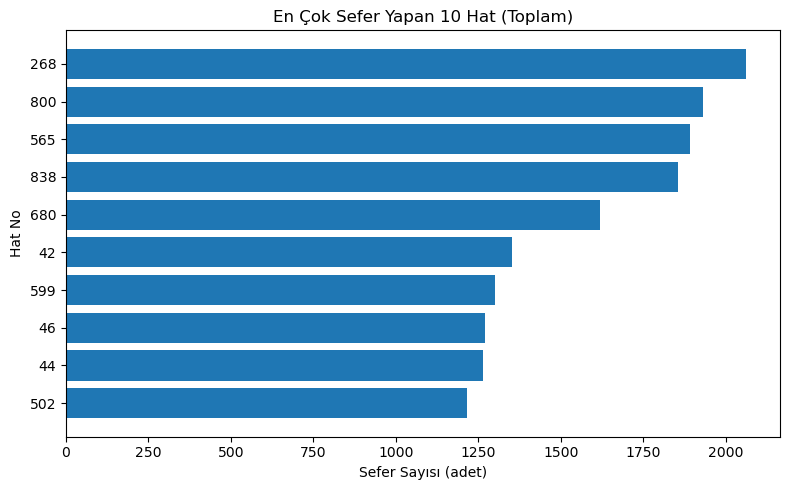

Hat 757: Sıra 48, Sefer 868
Hat 619: Sıra 58, Sefer 821


In [53]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# long hazır değilse hızlıca üret (hareket değişkeni varsa)
if 'long' not in globals():
    assert 'hareket' in globals(), "Önce veri hazırlık hücrelerini çalıştır (hareket/long oluşturulmalı)."
    tarife_map = {1: "Hafta içi", 2: "Cumartesi", 3: "Pazar"}
    hareket["HAT_NO"] = pd.to_numeric(hareket["HAT_NO"], errors="coerce")
    hareket["GUN"] = hareket["TARIFE_ID"].map(tarife_map)
    long = pd.melt(hareket, id_vars=["HAT_NO","TARIFE_ID","GUN"],
                   value_vars=["GIDIS_SAATI","DONUS_SAATI"],
                   var_name="YON", value_name="SAAT_STR")
    long = long[long["SAAT_STR"].str.match(r"^\d{2}:\d{2}$", na=False)].copy()
    long["SAAT"] = pd.to_datetime(long["SAAT_STR"], format="%H:%M").dt.hour

# ---- Genel sıralama
overall = (long.groupby("HAT_NO").size()
           .rename("SEFER_SAYISI").reset_index()
           .sort_values("SEFER_SAYISI", ascending=False).reset_index(drop=True))
overall["SIRA"] = np.arange(1, len(overall)+1)
display(overall.head(30))  # Top 30 tablo

# CSV olarak kaydet
out_dir = Path(".")
overall_csv = out_dir / "top_hats_overall.csv"
overall.to_csv(overall_csv, index=False, encoding="utf-8")
print("Kaydedildi:", overall_csv.as_posix())

# ---- Top 10 bar (tek grafik)
top10 = overall.head(10).iloc[::-1]  # y ekseninde büyükten küçüğe
plt.figure(figsize=(8,5))
plt.barh(top10["HAT_NO"].astype(str), top10["SEFER_SAYISI"])
plt.title("En Çok Sefer Yapan 10 Hat (Toplam)")
plt.xlabel("Sefer Sayısı (adet)"); plt.ylabel("Hat No")
plt.tight_layout(); plt.show()

# İlgilendiğimiz hatlar nerede?
for h in [757, 619]:
    row = overall.loc[overall["HAT_NO"]==h, ["SIRA","SEFER_SAYISI"]]
    if not row.empty:
        print(f"Hat {h}: Sıra {int(row.iloc[0,0])}, Sefer {int(row.iloc[0,1])}")
    else:
        print(f"Hat {h}: veri setinde yok.")



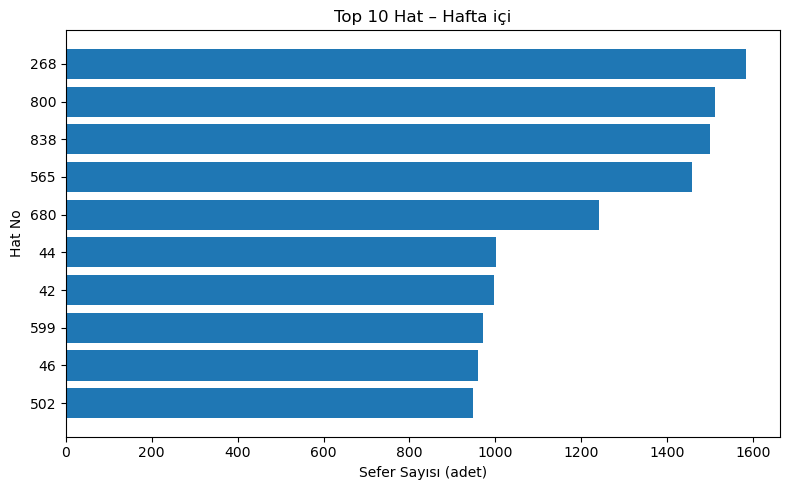

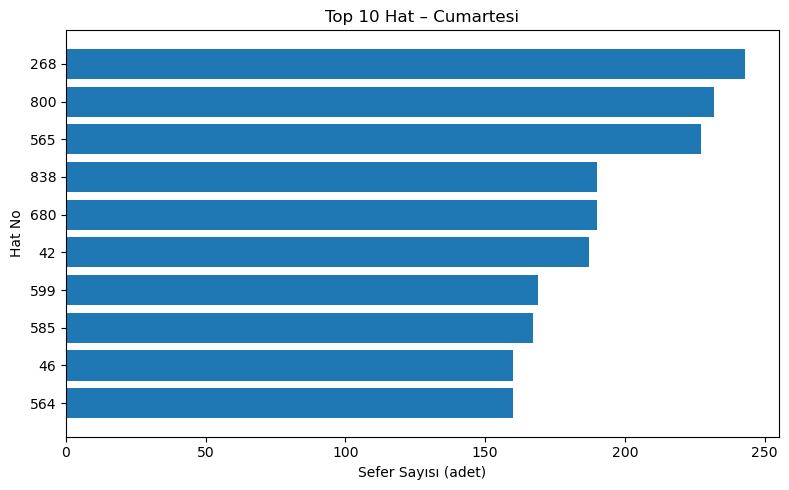

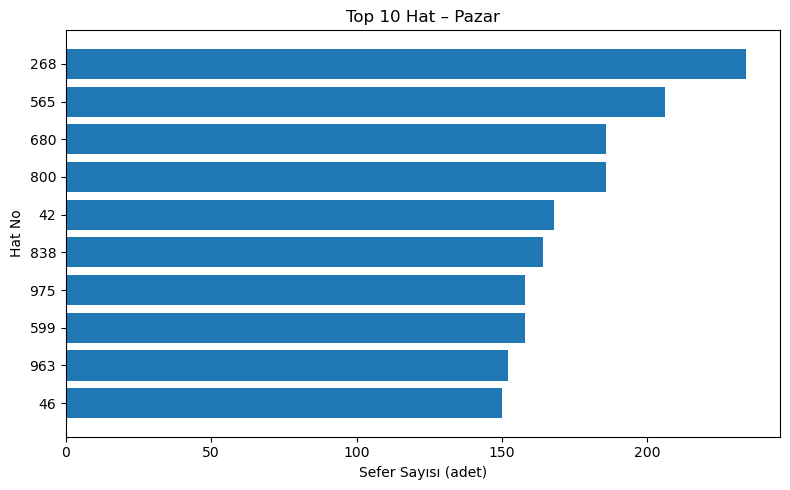

In [55]:
# Gün tipine göre Top 10 (her biri ayrı grafik)
by_day = (long.groupby(["HAT_NO","GUN"]).size()
          .rename("SEFER_SAYISI").reset_index())

for gun in ["Hafta içi","Cumartesi","Pazar"]:
    df = (by_day[by_day["GUN"]==gun]
          .sort_values("SEFER_SAYISI", ascending=False).head(10).iloc[::-1])
    if df.empty:
        continue
    plt.figure(figsize=(8,5))
    plt.barh(df["HAT_NO"].astype(str), df["SEFER_SAYISI"])
    plt.title(f"Top 10 Hat – {gun}")
    plt.xlabel("Sefer Sayısı (adet)"); plt.ylabel("Hat No")
    plt.tight_layout(); plt.show()


### K-Means

C:\Users\cemre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\cemre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\cemre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\cemre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Seçilen k: 3 | Silhouette: 0.491


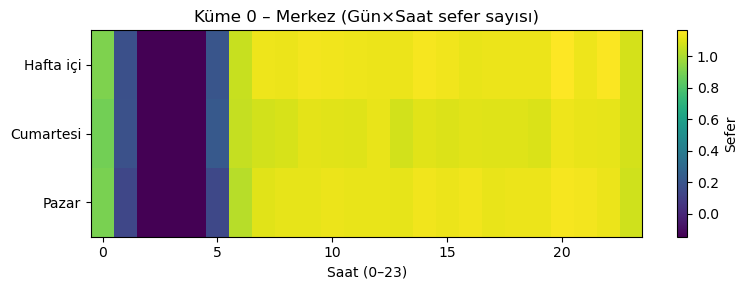

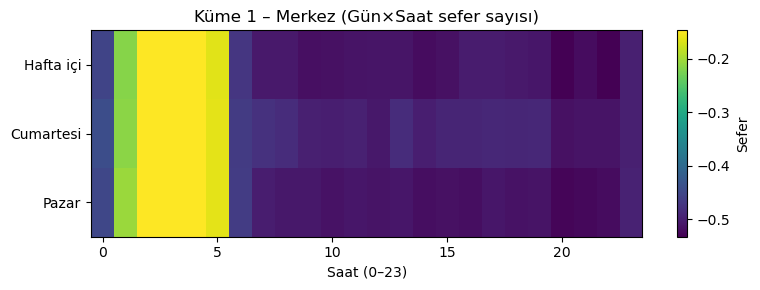

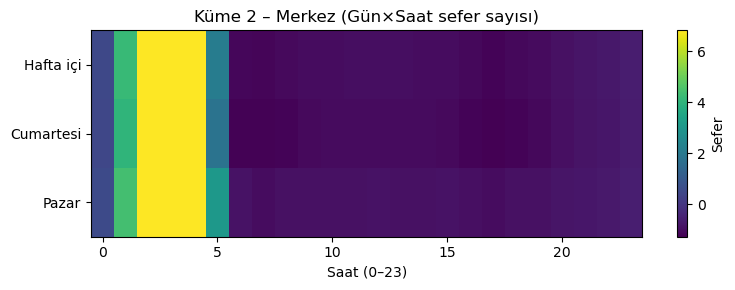

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from threadpoolctl import threadpool_limits
import numpy as np, matplotlib.pyplot as plt, pandas as pd

# 72D hat vektörü (gün×saat sefer sayısı)
feat = (long.groupby(["HAT_NO","GUN","SAAT"]).size()
        .rename("cnt").reset_index()
        .pivot_table(index="HAT_NO", columns=["GUN","SAAT"], values="cnt", fill_value=0))

X = StandardScaler().fit_transform(feat.values)

with threadpool_limits(limits=2, user_api='blas'):  # Windows uyarısı için
    sil = {}
    for k in range(2,6+1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(X)
        sil[k] = silhouette_score(X, km.labels_)
    best_k = max(sil, key=sil.get)
    kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42).fit(X)

feat["cluster"] = kmeans.labels_
print("Seçilen k:", best_k, "| Silhouette:", round(sil[best_k],3))

# Küme merkezlerini ısı haritası
gunlar = ["Hafta içi","Cumartesi","Pazar"]
centers = kmeans.cluster_centers_.reshape(best_k, 3, 24)
for c in range(best_k):
    plt.figure(figsize=(8,3))
    plt.imshow(centers[c], aspect="auto")
    plt.title(f"Küme {c} – Merkez (Gün×Saat sefer sayısı)")
    plt.yticks(range(3), gunlar); plt.xlabel("Saat (0–23)")
    plt.colorbar(label="Sefer"); plt.tight_layout(); plt.show()


### Sonuç

Bu çalışmada 757 ve 619 hatları için veriyi hazırlayıp gün×saat düzeyinde sefer yoğunluğu çıkardım. Isı haritaları, 757’de hafta içi 06–08 bandında keskin bir sabah zirvesi olduğunu; 619’da ise yoğunluğun gün boyu daha dengeli seyrettiğini ve iki hatta da hafta sonu belirgin düşüş yaşandığını gösterdi. Durak verisi ile yaptığım konumsal doğrulamada Ulukent Aktarma Merkezi ve Bakırçay Üniversitesi için ≤300 m içinde durak tespit ettim (erişim doğrulandı). Ek olarak “en çok sefer yapanlar” sıralaması genel tabloyu destekledi. K-Means ile 72 özellik üzerinden hat profillerini kümelendirerek benzer hizmet desenlerini ortaya koydum